# Montecarlo Packet Visualization

In [11]:
from tardis import run_tardis
from tardis.io.config_reader import Configuration
import plotly.express as px
import plotly.graph_objects as go
import math
import pandas as pd
import numpy as np
import random

In [12]:
# Reading the Configuration stored in `tardis_example.yml` into config

config = Configuration.from_yaml("tardis_example.yml")

In [13]:
# changing config file for plotting 15 packets

config["montecarlo"]["tracking"]["track_rpacket"]=True
config["montecarlo"]["seed"]= 457
config["montecarlo"]["no_of_packets"]=10
config["montecarlo"]["iterations"]=1
config["montecarlo"]["last_no_of_packets"]=15
config["montecarlo"]["no_of_virtual_packets"]=3

In [14]:
sim = run_tardis(config, show_progress_bars=False)

[tardis.plasma.standard_plasmas][INFO   ]  
	
	Reading Atomic Data from kurucz_cd23_chianti_H_He.h5 (standard_plasmas.py:93)
[tardis.io.atom_data.util][INFO   ]  
	
	Atom Data kurucz_cd23_chianti_H_He.h5 not found in local path.
	Exists in TARDIS Data repo /home/jayant/Downloads/tardis-data/kurucz_cd23_chianti_H_He.h5 (util.py:33)
[tardis.io.atom_data.base][INFO   ]  
	Reading Atom Data with: UUID = 6f7b09e887a311e7a06b246e96350010 MD5  = 864f1753714343c41f99cb065710cace  (base.py:249)
[tardis.io.atom_data.base][INFO   ]  
	Non provided Atomic Data: synpp_refs, photoionization_data, yg_data, two_photon_data (base.py:253)
[py.warnings         ][WARNING]  
	/home/jayant/Desktop/tardis/tardis/plasma/properties/radiative_properties.py:93: RuntimeWarning:

invalid value encountered in true_divide

 (warnings.py:109)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 1 of 1 (base.py:381)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 7.917e+42 erg / s
	Luminosity absorb

In [15]:
# accessing the rpacket_tracker dataframe
sim.runner.rpacket_tracker_df

status        seed             r            nu        mu  \
index step                                                             
0     0          0  1198907283  1.235520e+15  1.550353e+14  0.494472   
      1          0  1198907283  1.286064e+15  1.550353e+14  0.550200   
      2          0  1198907283  1.336608e+15  1.550353e+14  0.595364   
      3          0  1198907283  1.387152e+15  1.550353e+14  0.632965   
      4          0  1198907283  1.437696e+15  1.550353e+14  0.664865   
...            ...         ...           ...           ...       ...   
14    16         0  1951128961  2.044224e+15  6.232667e+14  0.921115   
      17         0  1951128961  2.094768e+15  6.232667e+14  0.925028   
      18         0  1951128961  2.145312e+15  6.232667e+14  0.928654   
      19         0  1951128961  2.195856e+15  6.232667e+14  0.932019   
      20         1  1951128961  2.246400e+15  6.232667e+14  0.935149   

              energy  shell_id  interaction_type  
index step                                        
0     0     0.067899         0                -1  
      1     0.067899         1                -1  
      2     0.067899         2                -1  
      3     0.067899         3                -1  
      4     0.067899         4                -1  
...              ...       ...               ...  
14    16    0.068592        16                -1  
      17    0.068592        17                -1  
      18    0.068592        18                -1  
      19    0.068592        19                -1  
      20    0.068592        19                -1  

[259 rows x 8 columns]

## Finding packet coordinates

\
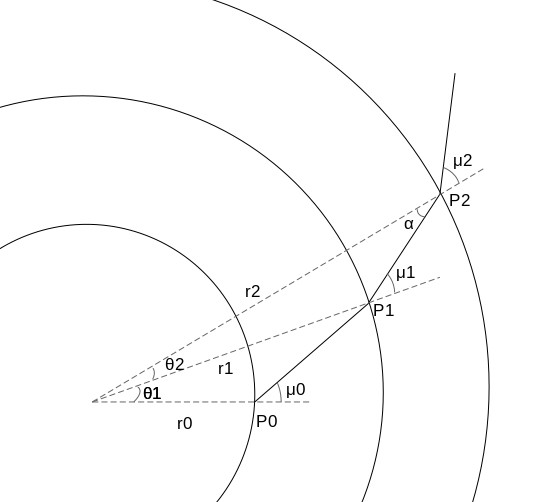

<br><br>The diagram above shows the packet trajectory as it starts from photosphere `P0` and continues to move along the subsequent points `P1`, `P2` and so on.

<div class="alert alert-info">
    <b>Note:</b><br>
    Here μ is the angle of direction of packet propagation with respect to line joining the center.
</div>

To determine the polar coordinates of any arbitrary point, let say `P2`, we need `r2` and `θ2`. `r2` is already present in the array obtained from the simulation. To determine `θ2`, we use sine rule and apply it on triangle `OP1P2`, where `O` is the center.

$$
\frac{r_{2}}{\sin(\pi - \mu_{1})} = \frac{r_{1}}{\sin(\alpha)}
$$

Now, writing `α` in terms of `μ1` and `θ2`

$$ 
α = μ_{1} - θ_{2} \\ \\
\frac{r_{2}}{\sin(\pi - \mu_{1})} = \frac{r_{1}}{\sin(μ_{1} - θ_{2})}
$$

Thus,

$$ 
θ_{2} = -\sin^{-1}(\frac{r1}{r2}\sin(\mu_{1})) + \mu_{1}
$$

Hence, for `ith` point, `θ` will be:

$$ 
θ_{i} = -\sin^{-1}(\frac{r_{i-1}}{r_{i}}\sin(\mu_{i-1})) + \mu_{i-1}
$$

In [16]:
# function for getting x y coordinates and interactions for a packet
def get_x_y_ints_with_theta_init(r_track,mu_track,time,last_interaction_type,direction="normal",theta_initial=0):
    xs,ys,theta,ints = [],[],[],[]
    
    for i in range(len(r_track)):
        if(i==0):
            theta.append(theta_initial)
        else:
            if(direction == 'random' or direction == 'r'):
                multiplier = random.choice([-1,1])
            elif(direction == 'opposite' or direction == 'o'):
                multiplier = -1
            else:
                multiplier = 1
            if (r_track[i]<r_track[i-1]):
                theta.append(theta[-1] - math.pi + math.asin(r_track[i-1]*math.sin(multiplier * math.acos(mu_track[i-1]))/r_track[i]) + multiplier * math.acos(mu_track[i-1]))
            else:
                theta.append(theta[-1]+math.asin(-1*r_track[i-1]*math.sin(multiplier * math.acos(mu_track[i-1]))/r_track[i]) + multiplier * math.acos(mu_track[i-1]))
                
                    
    xs = (np.array(r_track))*np.cos(np.array(theta))*1e-5/time
    ys = (np.array(r_track))*np.sin(np.array(theta))*1e-5/time
    
    for i in range(len(r_track)):
        if(i==0 or i == len(r_track)-1):
            ints.append(0)
        else:
            s0 = (ys[i]-ys[i-1])/(xs[i]-xs[i-1])
            s1 = (ys[i+1]-ys[i])/(xs[i+1]-xs[i])
            if(math.isclose(s0,s1,rel_tol=1e-11)):
                ints.append(0)
            else:
                ints.append(last_interaction_type[i])

    return xs,ys,ints

In [17]:
# function for getting coordinates of all packets
def get_coordinates_multiple_packets_ints(r_packet_tracker,time):
    thetas = np.linspace(0, 2*math.pi,sim.runner.rpacket_tracker_df.index[-1][0]+2)
    x = []
    y = []
    inters = []
    for i in range(sim.runner.rpacket_tracker_df.index[-1][0]+1):
        xs,ys,ints = get_x_y_ints_with_theta_init(r_packet_tracker.loc[i]["r"],r_packet_tracker.loc[i]["mu"],time,r_packet_tracker.loc[i]["interaction_type"],'n',thetas[i])
        x.append(xs)
        y.append(ys)
        inters.append(ints)
    return np.array(x,dtype="object"),np.array(y,dtype="object"),np.array(inters,dtype="object")

In [18]:
# function for normalizing array size for animation
def get_equal_array_size(xs,ys,ints):
    max_size = max(list(map(len,xs)))
    for i in range(len(xs)):
        xs[i] = np.append(xs[i],xs[i][-1]*np.ones([max_size-len(xs[i])]))
        ys[i] = np.append(ys[i],ys[i][-1]*np.ones([max_size-len(ys[i])]))
        ints[i] = np.append(ints[i],ints[i][-1]*np.ones([max_size-len(ints[i])]))
    return xs,ys,ints,max_size

## Plotting Packet Trajectories

In [28]:
# animated plot

v_shells = sim.model.radius.value * 1e-5 / sim.model.time_explosion.value
xs,ys,ints = get_coordinates_multiple_packets_ints(sim.runner.rpacket_tracker_df,sim.model.time_explosion.value)
xs,ys,ints,max_size = get_equal_array_size(xs,ys,ints)

fig = go.Figure()

# Set axes properties
fig.update_xaxes(range=[-1.1*v_shells[-1],1.1*v_shells[-1]],title="velocity (km/s)",exponentformat="none",linecolor="#555",gridcolor="#fafafa",zerolinecolor="#fafafa")
fig.update_yaxes(range=[-1.1*v_shells[-1],1.1*v_shells[-1]],title="velocity (km/s)",exponentformat="none",linecolor="#555",gridcolor="#fafafa",zerolinecolor="#fafafa")

# adding the shells
shell_shapes={}
for i in range(len(sim.model.radius.value)-2,-2,-1):
    if i==0:
        fig.add_shape(type="circle",
            xref="x", yref="y",
            x0=-1*v_shells[i], y0=-1*v_shells[i], x1=v_shells[i], y1=v_shells[i],
            line_color="black",
            fillcolor="darkgrey",
            opacity=1
        )
    elif i==(len(sim.model.radius.value)-1):
        fig.add_shape(type="circle",
            xref="x", yref="y",
            x0=-1*v_shells[i], y0=-1*v_shells[i], x1=v_shells[i], y1=v_shells[i],
            line_color="black",
            opacity=1
        )
    else:
        fig.add_shape(type="circle",
            xref="x", yref="y",
            x0=-1*v_shells[i], y0=-1*v_shells[i], x1=v_shells[i], y1=v_shells[i],
            line_color="black",
            opacity=0.1
        )

#Add the packet trajectory

df = sim.runner.rpacket_tracker_df
interaction_from_num = {0: "No Interaction", 1: "EScattering", 2: "Line"}
interaction_color_from_num = {0: "darkslategrey", 1: "#3366FF", 2: "#FF3300"}
interaction_opacity_from_num = {0: 0, 1: 1, 2: 1}

for i in range(len(xs)):
    fig.add_trace(go.Scatter(
        x=xs[i],
        y=ys[i],
        mode="markers+lines",
        name="Packet "+str(i+1),
        showlegend=False,
        hovertemplate =
        '<b>X</b>: %{x}'+
        '<br><b>Y</b>: %{y}<br>'+
        '<b>Last Interaction: %{text}</b>',
        text = [interaction_from_num.get(ints[i][j]) for j in range(len(xs[i]))],
        line = dict(color="darkslategrey"),
#         line_shape = "spline",
        marker = dict(opacity = [interaction_opacity_from_num.get(ints[i][j]) for j in range(len(xs[i]))],color=[interaction_color_from_num.get(ints[i][j]) for j in range(len(xs[i]))])
    ))

#adding legends
fig.add_trace(go.Scatter(
    x=[9999999],
    y=[0],
    legendgroup="a",
    opacity=1,
    legendgrouptitle=dict(font=dict(color="#444"),text="Interaction Type:"),
    mode="lines+markers",
    name="Escattering",
    hoverlabel=dict(font=dict(color="#222")),
    marker = dict(color="#3366FF"),
))
fig.add_trace(go.Scatter(
    x=[9999999],
    y=[0],
    legendgroup="a",
    opacity=1,
    mode="lines+markers",
    name="Line",
    marker = dict(color="#FF3300"),
))


# Set figure size
fig.layout.plot_bgcolor = '#fafafa'
fig.layout.paper_bgcolor = '#fafafa'

fig.update_layout(width=900, height=900,
                  title="Packet Trajectories",
                  title_font_color="#444",
                  updatemenus=[dict(type="buttons",
                                    pad=dict(t=750),
                                   buttons=[dict(label="Play",
                                                method="animate",
                                                args=[None])])])

# creating frames for animation
def get_frames(l):
    frames=[]
    for i in range(len(xs)):
        frames.append(go.Scatter(
            x=xs[i].tolist()[0:l],
            y=ys[i].tolist()[0:l],
            mode="markers+lines",
            name="Packet "+str(i+1),
            showlegend=False,
            hovertemplate =
            '<b>X</b>: %{x}'+
            '<br><b>Y</b>: %{y}<br>'+
            '<b>Last Interaction: %{text}</b>',
            text = [interaction_from_num.get(ints[i][j]) for j in range(len(xs[i]))],
            line = dict(color="darkslategrey"),
    #         line_shape = "spline",
            marker = dict(opacity = [interaction_opacity_from_num.get(ints[i][j]) for j in range(len(xs[i]))],color=[interaction_color_from_num.get(ints[i][j]) for j in range(len(xs[i]))])
        ))
    return frames
    
fig.frames=[go.Frame(data=get_frames(i)) for i in range(max_size+1)]

fig.show(renderer="notebook_connected")